
# Imports

In [1]:
########################## EDA
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from wordcloud import WordCloud

########################## Preprecessing
import spacy
import time
from tqdm import tqdm_notebook as tqdm
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

########################## Machine Learning
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes  import MultinomialNB
from sklearn.naive_bayes  import BernoulliNB
from sklearn.ensemble     import RandomForestClassifier
from xgboost              import XGBClassifier

########################## Machine Learning Evaluation
from sklearn.metrics         import accuracy_score, f1_score
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score


pd.set_option('max_colwidth', None)

# Read data

In [2]:
df = pd.read_csv("imdb.csv")

df_train = df.sample(frac = 0.8)
  
df_valid = df.drop(df_train.index)

print(f"Number of documents in training data:  {len(df_train)}")   #formatowanie 2 typy 
print("Number of documents in validation data: %d" % len(df_valid))

Number of documents in training data:  20000
Number of documents in validation data: 5000


In [7]:
df_train

,review,sentiment
4144,"Without a doubt, Private Lessons II is the greatest movie I have ever seen. A Japanese import (poorly) translated into English, its a joy to watch. Not much of it makes sense, but that doesn't matter. It's the greatest comedy around without ever being intentionally funny. The film is rare and unavailable on video, but I have caught it a couple of time late, late at night on pay cable. My taped copy has been watched dozens and dozens of times as I slowly, person-by-person, introduce this film gem to the world. Joanna Pacula plays the tutor/lover to Ken, our hero. (She apparently was just working for her check.) Ken is played by Goro Inagaki, of the Japanese pop band SMAP, who gives it his all and has great hair through out the movie. Stacy Edwards, of ""In the Company of Men"" fame, shows up in the movie too and is probably happy that she found other film work afterwards. It takes at least three viewings to sorta figure out what the plot is. On repeating viewing you can enjoy elements like the abnormal amount of vases Ken has in his house (at least 50) or that Ken is wearing a shirt with embroidered husks of corn in the movie's finale. The movie is predictable, but highly quotable. My friends and I reenact entire scenes. Yes, it sounds like we're lame losers and we are ... but we're lame losers who have seen ""Private Lessons II."" Be one of ten people in the world who have seen this movie. You'll thank me for it.",0
20086,"I saw the capsule comment said ""great acting."" In my opinion, these are two great actors giving horrible performances, and with zero chemistry with one another, for a great director in his all-time worst effort. Robert De Niro has to be the most ingenious and insightful illiterate of all time. Jane Fonda's performance uncomfortably drifts all over the map as she clearly has no handle on this character, mostly because the character is so poorly written. Molasses-like would be too swift an adjective for this film's excruciating pacing. Although the film's intent is to be an uplifting story of curing illiteracy, watching it is a true ""bummer."" I give it 1 out of 10, truly one of the worst 20 movies for its budget level that I have ever seen.",1
1708,"Robert Stack never really got over losing a Best Supporting Actor Oscar for his role as Kyle in ""Written on the Wind"" to Anthony Quinn's 12-minute performance in ""Lust for Life."" Stack plays the deeply disturbed, alcoholic son of an oil tycoon. He has lived his life in the shadow of the friend with whom he was raised, Mitch, played by Rock Hudson. They both love the same woman, Lucy, (Lauren Bacall), who becomes Kyle's wife. Kyle's sister, Marylee (Dorothy Malone), is a drunken slut who's in love with Mitch. Their story plays out in glorious color under the able direction of Douglas Sirk, who really dominated the melodrama field with some incredible films, including ""Imitation of Life,"" ""All that Heaven Allows,"" ""Magnificent Obsession,"" and many others. Make no mistake - this is a potboiler, and Stack and Dorothy Malone make the most of their roles, Malone winning a Best Supporting Actress Oscar. There's one amazing scene, mentioned in other comments, where she wildly dances to loud music as her father collapses and dies on the staircase. We're led to believe that Marylee sleeps with everyone, including the guy that pumps the gas, because she's in love with Mitch. Mitch wants nothing to do with her. He's so in love with Lucy that, out of loyalty to Kyle, he wants to go to work in Iran to avoid temptation. I doubt he'd be so anxious to get there today no matter how much in love he was. Hudson and Bacall have the less exciting roles here - Hudson's Mitch is the good guy who's been cleaning up Kyle's messes for his entire life, and Bacall is Mitch's wife who finds herself in a nightmare when her husband starts drinking again after a year of sobriety. Sirk focuses on the more volatile supporting players. In Sirk's hands, ""Written 

# EDA
### Target

C:\Users\Wojtek\anaconda3\envs\dl\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='sentiment', ylabel='count'>

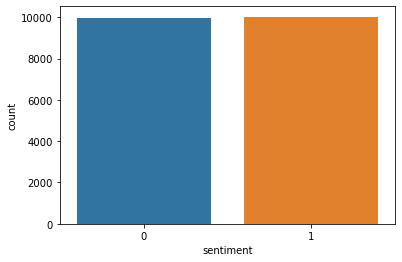

In [3]:
sb.countplot(df_train['sentiment'])

### Text

In [6]:
positive = df[df['sentiment']==0]['review']
negative = df[df['sentiment']==1]['review']

positive

ed Worms starts like any children's story: moving to a new town. The new kid, fifth grader Billy Forrester was once popular, but has to start anew. Making friends is never easy, especially when the only prospect is Poindexter Adam. Or Erica, who at 4 1/2 feet, is a giant.  Further complicating things is Joe the bully. His freckled face and sleeveless shirts are daunting. He antagonizes kids with the Death Ring: a Crackerjack ring that is rumored to kill you if you're punched with it. But not immediately. No, the death ring unleashes a poison that kills you in the eight grade.  Joe and his axis of evil welcome Billy by smuggling a handful of slimy worms into his thermos. Once discovered, Billy plays it cool, swearing that he eats worms all the time. Then he throws them at Joe's face. Ewww! To win them over, Billy reluctantly bets that he can eat 10 worms. Fried, boiled, marinated in hot sauce, squashed and spread on a peanut butter sandwich. Each meal is dubbed an exotic name like the "

Wall time: 17.9 s


Text(0.5, 1.0, 'Negative')

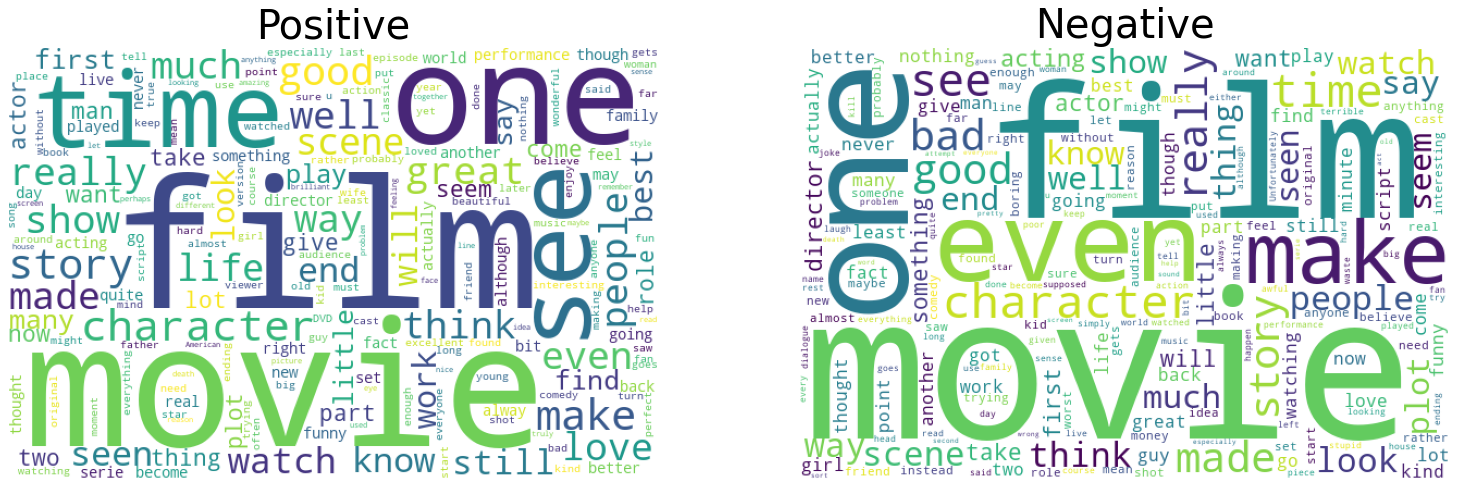

In [8]:
%%time
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[26, 8])

wordcloud1 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(positive))
ax1.imshow(wordcloud1)
ax1.axis('off')
ax1.set_title('Positive', fontsize=40);

wordcloud2 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(negative))
ax2.imshow(wordcloud2)
ax2.axis('off')
ax2.set_title('Negative',fontsize=40);

# NLP Preprocessing

Before we start with any NLP project we need to pre-process the data to get it all in a consistent format.We need to clean, tokenize and convert our data into a matrix. Some of the basic text pre-processing techniques includes:

- Make text all **lower case** or **upper case** so that the algorithm does not treat the same words in different cases as different
- **Removing Noise** i.e everything that isn’t in a standard number or letter i.e Punctuation, Numerical values, common non-sensical text (/n)
- **Tokenization**: Tokenization is just the term used to describe the process of converting the normal text strings into a list of tokens i.e words that we actually want. Sentence tokenizer can be used to find the list of sentences and Word tokenizer can be used to find the list of words in strings.
- **Stopword Removal**: Sometimes, some extremely common words which would appear to be of little value in helping select documents matching a user need are excluded from the vocabulary entirely. These words are called stop words

### More data cleaning steps after tokenization:
- **Stemming**: Stemming is the process of reducing inflected (or sometimes derived) words to their stem, base or root form — generally a written word form. Example if we were to stem the following words: “Stems”, “Stemming”, “Stemmed”, “and Stemtization”, the result would be a single word “stem”.
- **Lemmatization**: A slight variant of stemming is lemmatization. The major difference between these is, that, stemming can often create non-existent words, whereas lemmas are actual words. So, your root stem, meaning the word you end up with, is not something you can just look up in a dictionary, but you can look up a lemma. Examples of Lemmatization are that “run” is a base form for words like “running” or “ran” or that the word “better” and “good” are in the same lemma so they are considered the same.
- **Parts of speech** tagging
- Create **bi-grams** or tri-grams And more...

However, it is not necessary that you would need to use all these steps. The usage depends on your problem at hand. Sometimes removal of stop words helps while at other times, this might not help.Here is a nice table taken from the blog titled: [All you need to know about Text Preprocessing for Machine Learning & NLP](https://kavita-ganesan.com/text-preprocessing-tutorial) that summarizes how much preprocessing you should be performing on your text data:

# <center> Toy Example

In [7]:
texts = [
    'Hello this is an sentence',
    'Hello this is another sentence',
    'Hello Hello Hello, this is mellow'
]

### Bag Of Words (BOW)

In [1]:
# create a CountVectorizer instance
# fit tranform the text with it
# get the features+

bow = 0
texts_bow = 0
tokens = 0
pd.DataFrame(data=texts_bow.toarray(), index=['Text 1', 'Text 2', "Text 3"], columns=tokens)

NameError: name 'pd' is not defined

### Bag Of Words (BOW) + ngram

In [9]:
#do the same approach but using a range in the count vectorizer
pd.DataFrame(data=texts_bow.toarray(), index=['Text 1', 'Text 2', "Text 3"], columns=tokens)

,es,es otra,es una,esto,esto es,frase,hola,hola esto,hola hola,hola no,no,no vengas,otra,otra frase,sola,una,una frase,vengas,vengas sola
Text 1,1,0,1,1,1,1,1,1,0,0,0,0,0,0,0,1,1,0,0
Text 2,1,1,0,1,1,1,1,1,0,0,0,0,1,1,0,0,0,0,0
Text 3,0,0,0,0,0,0,3,0,2,1,1,1,0,0,1,0,0,1,1


### TFIDF
A problem with the Bag of Words approach is that highly frequent words start to dominate in the document (e.g. larger score), but may not contain as much “informational content”. Also, it will give more weight to longer documents than shorter documents.

One approach is to rescale the frequency of words by how often they appear in all documents so that the scores for frequent words like “the” that are also frequent across all documents are penalized. This approach to scoring is called Term Frequency-Inverse Document Frequency, or TF-IDF for short, where:

- **Term Frequency**: is a scoring of the frequency of the word in the current document.
- **Inverse Document Frequency**: is a scoring of how rare the word is across documents.

In [10]:
#Same approach for the TfidfVectorizer
pd.DataFrame(data=texts_tfidf.toarray(), index=['Text 1', 'Text 2', "Text 3"], columns=tokens)

,es,esto,frase,hola,no,otra,sola,una,vengas
Text 1,0.433067,0.433067,0.433067,0.336315,0.000000,0.000000,0.000000,0.569431,0.000000
Text 2,0.433067,0.433067,0.433067,0.336315,0.000000,0.569431,0.000000,0.000000,0.000000
Text 3,0.000000,0.000000,0.000000,0.715092,0.403585,0.000000,0.403585,0.000000,0.403585


# <center> Apply to the reviews

### Bag Of Words 1-gram

In [11]:
%%time
bow_1gram = CountVectorizer()

train_bow_1gram = 0
valid_bow_1gram = 0

CPU times: user 5.22 s, sys: 27.5 ms, total: 5.25 s
Wall time: 5.25 s


### Bag Of Words 1-2-grams

In [12]:
%%time
bow_2grams = 0
train_bow_2grams = 0
valid_bow_2grams = 0

CPU times: user 16.9 s, sys: 269 ms, total: 17.2 s
Wall time: 17.2 s


### TFIDF 1-gram

In [13]:
%%time
tfidf_1gram       = 0
train_tfidf_1gram = 0
valid_tfidf_1gram = 0

CPU times: user 5.54 s, sys: 9.89 ms, total: 5.55 s
Wall time: 5.55 s


### TFIDF 1-2-grams

In [14]:
%%time
tfidf_2grams      = 0
train_tfidf_2grams = 0
valid_tfidf_2grams = 0

CPU times: user 15.3 s, sys: 213 ms, total: 15.5 s
Wall time: 15.5 s


In [16]:
data = [
    ("BOW 1gram",   train_bow_1gram, valid_bow_1gram),
    ("BOW 2grams",  train_bow_2grams, valid_bow_2grams),
    ("TFIDF 1gram", train_tfidf_1gram, valid_tfidf_1gram),
    ("TFIDF 2grams",train_tfidf_2grams, valid_tfidf_2grams)
]

print("BOW 1gram   ", train_bow_1gram.shape)
print("BOW 2grams  ", train_bow_2grams.shape)
print("TFIDF 1gram ", train_tfidf_1gram.shape)
print("TFIDF 2grams", train_tfidf_2grams.shape)

BOW 1gram    (25000, 76496)
BOW 2grams   (25000, 1513369)
TFIDF 1gram  (25000, 45185)
TFIDF 2grams (25000, 433699)


# <center> ML Models

## Naive Bayes (<1 s)

In [24]:
for name, x_train, x_valid in data:
    
    #Train a MultinomialNB model and meassure the time

    a = accuracy_score(y_valid, model.predict(x_valid))
    print(name, "\tAccuracy:\t", a, "\tTime:\t", t)

BOW 1gram 	Accuracy:	 0.84428 	Time:	 0.018774747848510742
BOW 2grams 	Accuracy:	 0.878 	Time:	 0.13236117362976074
TFIDF 1gram 	Accuracy:	 0.8604 	Time:	 0.014917850494384766
TFIDF 2grams 	Accuracy:	 0.88544 	Time:	 0.05532026290893555


## Logistic Regression (30s)

In [25]:
for name, x_train, x_valid in data:
    #Train a LogisticRegression model and meassure the time

    print(name, "\tAccuracy:\t", a, "\tTime:\t", t)

BOW 1gram 	Accuracy:	 0.8856 	Time:	 2.3662497997283936
BOW 2grams 	Accuracy:	 0.90076 	Time:	 23.640942335128784
TFIDF 1gram 	Accuracy:	 0.89168 	Time:	 1.5041086673736572
TFIDF 2grams 	Accuracy:	 0.89688 	Time:	 3.6333465576171875


## Random Forest (10+90+6+22 segundos)

In [26]:
for name, x_train, x_valid in data:
    #Train a RandomForestClassifier model and meassure the time
    print(name, "\tAccuracy:\t", a, "\tTime:\t", t)

BOW 1gram 	Accuracy:	 0.8482 	Time:	 13.228048086166382
BOW 2grams 	Accuracy:	 0.85832 	Time:	 93.41943311691284
TFIDF 1gram 	Accuracy:	 0.8454 	Time:	 9.45107913017273
TFIDF 2grams 	Accuracy:	 0.8552 	Time:	 27.58473038673401
